In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
[Quickstart](quickstart_tutorial.html) ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
**Optimization** ||
[Save & Load Model](saveloadrun_tutorial.html)

# Optimizing Model Parameters

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on
our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates
the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these parameters using gradient descent. For a more
detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8)_.

## Prerequisite Code
We load the code from the previous sections on [Datasets & DataLoaders](data_tutorial.html)
and [Build Model](buildmodel_tutorial.html).


In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cuda"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

workers = 0
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=workers)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv = nn.Sequential(
        #     nn.Conv2d(1, 32, 3, padding=1),
        #     nn.BatchNorm2d(32),
        #     # nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(32, 64, 3, padding=1),
        #     nn.BatchNorm2d(64),
        #     # nn.ReLU(),
        #     nn.MaxPool2d(2),
        # )
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(64 * 28 * 28, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 10),
        # )
        self.conv = nn.Sequential( # B 1 28 28 
            nn.Conv2d(1, 32, 5), # B 32 24 24
            nn.MaxPool2d(2), # B 32 12 12
            nn.Conv2d(32, 128, 3), # B 128 10 10
            nn.MaxPool2d(2), # B 128 5 5
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 5 * 5, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim = 1)
        logits = self.fc(x)
        return logits

model = NeuralNetwork().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}")

Using cuda device
Number of parameters: 1,810,634


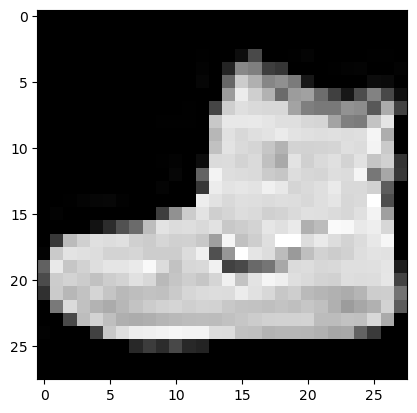

In [33]:
import matplotlib.pyplot as plt

image, label = next(iter(training_data))
# print(image)
plt.imshow(image.squeeze(), cmap="gray")
# print(label)

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [34]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [35]:
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.




## Full Implementation
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that
evaluates the model's performance against our test data.



In [36]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]", end = "\t")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.



In [37]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 3e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

epochs = 100
no_improve_epochs = 0
best = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    res = test_loop(test_dataloader, model, loss_fn)
    if res < best + 1:
        no_improve_epochs += 1
    else:
        no_improve_epochs = 0
    if no_improve_epochs == 3:
        break
    best = max(best, res)

print("Done!")

Epoch 1
-------------------------------
loss: 2.303750  [  128/60000]	loss: 0.504527  [12928/60000]	loss: 0.468412  [25728/60000]	loss: 0.436726  [38528/60000]	loss: 0.498205  [51328/60000]	
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.444460 

Epoch 2
-------------------------------
loss: 0.317340  [  128/60000]	loss: 0.304899  [12928/60000]	loss: 0.275559  [25728/60000]	loss: 0.348659  [38528/60000]	loss: 0.403341  [51328/60000]	
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.357654 

Epoch 3
-------------------------------
loss: 0.214944  [  128/60000]	loss: 0.224322  [12928/60000]	loss: 0.236083  [25728/60000]	loss: 0.320857  [38528/60000]	loss: 0.324067  [51328/60000]	
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.323607 

Epoch 4
-------------------------------
loss: 0.178455  [  128/60000]	loss: 0.195119  [12928/60000]	loss: 0.220475  [25728/60000]	loss: 0.300699  [38528/60000]	loss: 0.276157  [51328/60000]	
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.309077 

Epoch 5
--------------------

## Further Reading
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)
- [Warmstart Training a Model](https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html)


